<div style="
    padding: 15px;
    margin: 10px 0;
    border: 1px solid #f7be0d;
    border-radius: 4px;
    background-color: #e3db24;
    color: #060606;
    font-size: 16px;
    line-height: 1.5;
    word-wrap: break-word;
    text-align: left;">
    <strong>Inferential Statistics</strong>
<p>This notebook builds on the notebook "EDA-maternal-employment" which can be found in the same repo. In "EDA-maternal-employment" hypotheses regarding influence factors on the maternal employment were put forward and tested with EDA methods. They will be put down here and further tested with inferential methods ONLY if a relationship was indicated in the previous work.</p>
</div>

<h1 style="color: #e3db24;">00 | Libraries and Settings</h1>

In [31]:
# 📚 Basic libraries
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# 🛞 Machine Learning
import xgboost as xgb
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [32]:
# ⚙️ Settings
pd.set_option('display.max_columns', None) # display all columns
pd.set_option('display.float_format', '{:,.2f}'.format)
import warnings
warnings.filterwarnings('ignore') # ignore warnings

<h1 style="color: #e3db24;">01 | Data Extraction</h1>

In [33]:
eda_df = pd.read_excel('data/eda_df.xlsx')
eu_df = pd.read_excel('data/eu_df.xlsx')

In [34]:
eu_df.head()

,country,gdp,fertility,unemployment,spending_family_benefits,pay_gap,age_first_child,women_15-49,emp_women,emp_men,emp_women_pt,emp_men_pt,manager_women,edu_women_score,edu_women_cat,emp_mothers_partnered,emp_mothers_single,fathers_full_paid_leave,mothers_full_paid_leave,emp_pt_maternal,emp_ft_maternal,emp_maternal
0,Austria,38560,1.48,5.30,2.70,12.14,29.70,37.20,70.30,77.90,50.10,12.20,35.50,2.10,High,75.83,73.27,9.39,51.20,40.38,35.18,75.56
1,Belgium,37170,1.60,5.30,2.06,1.11,29.20,37.20,63.30,69.90,38.10,10.70,35.40,2.21,High,77.99,64.04,6.65,15.05,19.72,55.63,75.53
2,Bulgaria,7730,1.58,4.40,1.59,8.81,26.40,33.30,67.40,73.90,1.50,1.30,38.30,2.11,High,71.95,67.10,1.93,73.14,0.61,68.52,71.13
3,Croatia,14630,1.58,6.00,1.85,3.21,29.00,35.20,62.10,69.40,4.50,3.00,28.90,2.07,Medium,77.43,81.50,7.87,47.62,3.87,73.13,77.79
4,Cyprus,28790,1.39,5.70,0.93,20.84,30.00,43.50,71.40,79.30,10.90,5.80,21.00,2.28,High,74.37,64.38,1.44,15.84,7.63,65.54,73.18


In [35]:
eda_df.head()

,country,emp_maternal,spending_family_benefits,fathers_full_paid_leave,emp_mothers_partnered,emp_mothers_single,edu_women_score,edu_women_cat,manager_women,emp_men_pt,pay_gap,spending_category
0,Austria,75.56,2.70,9.39,75.83,73.27,2.10,High,35.50,12.20,12.14,High
1,Belgium,75.53,2.06,6.65,77.99,64.04,2.21,High,35.40,10.70,1.11,Medium-High
2,Bulgaria,71.13,1.59,1.93,71.95,67.10,2.11,High,38.30,1.30,8.81,Medium-Low
3,Croatia,77.79,1.85,7.87,77.43,81.50,2.07,Medium,28.90,3.00,3.21,Medium-Low
4,Cyprus,73.18,0.93,1.44,74.37,64.38,2.28,High,21.00,5.80,20.84,Low


<h2 style="color: #ec7511;">Copy as Best Practice</h2>

In [36]:
inf_df = eda_df.copy()
regression_all = eu_df.copy()

## <span style="color: #ec7511;">Moving the Target to the Right</span>

In [37]:
#eu_df = eu_df[[col for col in eu_df.columns if col != "emp_women"] + ["emp_women"]]
#df_women = eu_df[[col for col in eu_df.columns if col != "emp_women"] + ["emp_women"]]
#df_mothers = eu_df[[col for col in eu_df.columns if col != "emp_mothers"] + ["emp_mothers"]]

<h1 style="color: #e3db24;">02 | Hypothesis Testing</h1>

<div style="
    padding: 15px;
    margin: 10px 0;
    border: 1px solid #f7be0d;
    border-radius: 4px;
    background-color: #e3db24;
    color: #060606;
    font-size: 16px;
    line-height: 1.5;
    word-wrap: break-word;
    text-align: left;">
    <strong>Overview Hypotheses:</strong>
<p>These are the four hypotheses for which the EDA analysis before indicated confirmation and a relationship between the variables.</p>
<ul>
    <li><strong>H2:</strong> Mothers in partnerships have a higher employment rate than single mothers. This difference is smaller in countries with higher spending on family benefits.</li>
    <li><strong>H3:</strong> Countries with longer fully paid parental leave for fathers have a higher maternal employment rate.</li>
    <li><strong>H4:</strong> The higher the education level of women in a country, the higher the maternal employment rate.</li>
    <li><strong>H6:</strong> In countries where more men work part-time, maternal employment rates are higher.</li>
</ul>
<p>In the following, I will analyse the detected relationship with inferential methods like t-tests, ANOVA and linear regression. Afterwards, I will build a comprehensive modell for a multiple regression which also includes control variables like GDP, unemployment and several more parameters.</p>
</div>

## <span style="color: #ec7511;">Hypothesis 2:</span>
<p>Mothers in partnerships have a higher employment rate than single mothers. This difference is smaller in countries with higher spending on family benefits.</p>

### <span style="color: #ec300e;">Independent Two Sample T-Test Between Single and Partnered Mothers</span>

In [38]:
# two sample t-test for the means of two independent samples
group1 = eda_df["emp_mothers_single"]
group2 = eda_df["emp_mothers_partnered"]

t_stat, p_value = stats.ttest_ind(group1, group2)

print(f"T-Statistik: {t_stat:.3f}")
print(f"p-Wert: {p_value:.3f}")
print("")

if p_value < 0.05:
    print("\n🚨 Significant difference between the means of the two groups (p < 0.05)")
else:
    print("\n❎ No significant difference between the means of the two group (p >= 0.05)")

T-Statistik: -1.759
p-Wert: 0.085


❎ No significant difference between the means of the two group (p >= 0.05)


### <span style="color: #ec300e;">One Way ANOVA on the Impact of Public Spending on the Employment Rate of Single/Partnered Mothers</span>

In [39]:
# ANOVA for single mothers
anova_single = stats.f_oneway(
    eda_df[eda_df["spending_category"] == "Low"]["emp_mothers_single"],
    eda_df[eda_df["spending_category"] == "Medium-Low"]["emp_mothers_single"],
    eda_df[eda_df["spending_category"] == "Medium-High"]["emp_mothers_single"],
    eda_df[eda_df["spending_category"] == "High"]["emp_mothers_single"]
)

# ANOVA for partnered mothers
anova_partnered = stats.f_oneway(
    eda_df[eda_df["spending_category"] == "Low"]["emp_mothers_partnered"],
    eda_df[eda_df["spending_category"] == "Medium-Low"]["emp_mothers_partnered"],
    eda_df[eda_df["spending_category"] == "Medium-High"]["emp_mothers_partnered"],
    eda_df[eda_df["spending_category"] == "High"]["emp_mothers_partnered"]
)

# Ergebnisse ausgeben
print("ANOVA for Single Mothers")
print(f"F-value: {anova_single.statistic:.3f}, p-value: {anova_single.pvalue:.3f}")
print("\nANOVA for Partnered Mothers")
print(f"F-value: {anova_partnered.statistic:.3f}, p-value: {anova_partnered.pvalue:.3f}")

# Interpretation
alpha = 0.05
if anova_single.pvalue < alpha:
    print("\n🚨 There is a significant difference in the employment rate of single mothers between the categories of spending on family benefits.")
else:
    print("\n❎ There is NO significant difference in the employment rate of single mothers between the categories of spending on family benefits.")

if anova_partnered.pvalue < alpha:
    print("\n🚨 There is a significant difference in the employment rate of partnered mothers between the categories of spending on family benefits.")
else:
    print("\n❎ There is NO significant difference in the employment rate of partnered mothers between the categories of spending on family benefits.")


ANOVA for Single Mothers
F-value: 1.699, p-value: 0.198

ANOVA for Partnered Mothers
F-value: 0.123, p-value: 0.946

❎ There is NO significant difference in the employment rate of single mothers between the categories of spending on family benefits.

❎ There is NO significant difference in the employment rate of partnered mothers between the categories of spending on family benefits.


<div style="
    padding: 15px;
    margin: 10px 0;
    border: 1px solid #2d0df7;
    border-radius: 4px;
    background-color: #0dd4f7;
    color: #060606;
    font-size: 16px;
    line-height: 1.5;
    word-wrap: break-word;
    text-align: left;">
    <strong>Conclusions: ...</strong>
<p>TEXT</p>
</div>

## <span style="color: #ec7511;">Hypothesis 3:</span>
<p>Countries with longer fully paid parental leave for fathers have a higher maternal employment rate.</p>

### <span style="color: #ec300e;">OLS Regression of Paternal Leave on Maternal Employment</span>

In [40]:
# independent variable (predictor)
X = eda_df["fathers_full_paid_leave"]
X = sm.add_constant(X)  # add constant term (intercept, the predicted y value when x=0)

# dependent variable (target)
y = eda_df["emp_maternal"]

# OLS regression
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           emp_maternal   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     2.144
Date:                Sun, 09 Feb 2025   Prob (F-statistic):              0.157
Time:                        18:17:22   Log-Likelihood:                -83.424
No. Observations:                  25   AIC:                             170.8
Df Residuals:                      23   BIC:                             173.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

<div style="
    padding: 15px;
    margin: 10px 0;
    border: 1px solid #2d0df7;
    border-radius: 4px;
    background-color: #0dd4f7;
    color: #060606;
    font-size: 16px;
    line-height: 1.5;
    word-wrap: break-word;
    text-align: left;">
    <strong>Conclusions: ...</strong>
<p>TEXT</p>
    <ul>
        <li>not significant</li>
        <li>TEXT</li>
        <li>TEXT</li>
        <li>TEXT</li>
    </ul>
</div>

## <span style="color: #ec7511;">Hypothesis 4:</span>
<p>The higher the education level of women in a country, the higher the maternal employment rate.</p>

### <span style="color: #ec300e;">One Way ANOVA on the Effect of Different Education Level Categories on Maternal Employment</span>

In [41]:
# ANOVA for influence of edu_women_cat on emp_maternal
anova_edu = stats.f_oneway(
    eda_df[eda_df["edu_women_cat"] == "Low"]["emp_maternal"],
    eda_df[eda_df["edu_women_cat"] == "Medium"]["emp_maternal"],
    eda_df[eda_df["edu_women_cat"] == "High"]["emp_maternal"]
)

print("ANOVA for the influence of edu_women_cat on emp_maternal")
print(f"F-value: {anova_edu.statistic:.3f}, p-value: {anova_edu.pvalue:.3f}")

# Interpretation
alpha = 0.05
if anova_edu.pvalue < alpha:
    print("\n🚨 There is a significant difference in the employment rate of mothers between the different categories of education levels.")
else:
    print("\n❎  There is NO significant difference in the employment rate of mothers between the different categories of education levels.")

ANOVA for the influence of edu_women_cat on emp_maternal
F-value: 2.776, p-value: 0.084

❎  There is NO significant difference in the employment rate of mothers between the different categories of education levels.


### <span style="color: #ec300e;">OLS Regression on the Effect of Different Education Level Scores on Maternal Employment</span>

In [42]:
# independent variable (predictor)
X = eda_df["edu_women_score"]
X = sm.add_constant(X)  # add constant term (intercept, the predicted y value when x=0)

# dependent variable (target)
y = eda_df["emp_maternal"]

# OLS regression
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           emp_maternal   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     6.361
Date:                Sun, 09 Feb 2025   Prob (F-statistic):             0.0190
Time:                        18:17:22   Log-Likelihood:                -81.486
No. Observations:                  25   AIC:                             167.0
Df Residuals:                      23   BIC:                             169.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              24.7332     19.777     

<div style="
    padding: 15px;
    margin: 10px 0;
    border: 1px solid #2d0df7;
    border-radius: 4px;
    background-color: #0dd4f7;
    color: #060606;
    font-size: 16px;
    line-height: 1.5;
    word-wrap: break-word;
    text-align: left;">
    <strong>Conclusions: ...</strong>
<p>YES FINALLY FOUND SOMETHING</p>
    <ul>
        <li>OLS interpretation: 18.3% of emp_maternal is explained by education level score. Significant: f-statistics p<0.05! The coefficient of 23.19 shows: an increase of 1 point in the education score would lead to an increase in the employment rate of 23.2 %.</li>
        <li>TEXT</li>
        <li>TEXT</li>
        <li>TEXT</li>
    </ul>
</div>

## <span style="color: #ec7511;">Hypothesis 6:</span>
<p>In countries where more men work part-time, maternal employment rates are higher.</p>

### <span style="color: #ec300e;">OLS Regression on the Effect of Male Part-Time Employment Rate on Maternal Employment</span>

In [43]:
# independent variable (predictor)
X = eda_df["emp_men_pt"]
X = sm.add_constant(X)  # add constant term (intercept, the predicted y value when x=0)

# dependent variable (target)
y = eda_df["emp_maternal"]

# OLS regression
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           emp_maternal   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     2.537
Date:                Sun, 09 Feb 2025   Prob (F-statistic):              0.125
Time:                        18:17:22   Log-Likelihood:                -83.231
No. Observations:                  25   AIC:                             170.5
Df Residuals:                      23   BIC:                             172.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.9265      2.650     26.761      0.0

<div style="
    padding: 15px;
    margin: 10px 0;
    border: 1px solid #2d0df7;
    border-radius: 4px;
    background-color: #0dd4f7;
    color: #060606;
    font-size: 16px;
    line-height: 1.5;
    word-wrap: break-word;
    text-align: left;">
    <strong>Conclusions: ...</strong>
<p>TEXT</p>
    <ul>
        <li>not significant</li>
        <li>TEXT</li>
        <li>TEXT</li>
        <li>TEXT</li>
    </ul>
</div>

<h1 style="color: #e3db24;">03 | Multiple Regression</h1>

<div style="
    padding: 15px;
    margin: 10px 0;
    border: 1px solid #f7be0d;
    border-radius: 4px;
    background-color: #e3db24;
    color: #060606;
    font-size: 16px;
    line-height: 1.5;
    word-wrap: break-word;
    text-align: left;">
    <strong>Next Steps:</strong>
<p>changes to df</p>
    <ul>
        <li>erase categorial variables because they were created from numerical data, so the information is there</li>
        <li>TEXT</li>
        <li>TEXT</li>
        <li>TEXT</li>
    </ul>
</div>

In [44]:
eu_df.head().T

,0,1,2,3,4
country,Austria,Belgium,Bulgaria,Croatia,Cyprus
gdp,38560,37170,7730,14630,28790
fertility,1.48,1.60,1.58,1.58,1.39
unemployment,5.30,5.30,4.40,6.00,5.70
spending_family_benefits,2.70,2.06,1.59,1.85,0.93
pay_gap,12.14,1.11,8.81,3.21,20.84
age_first_child,29.70,29.20,26.40,29.00,30.00
women_15-49,37.20,37.20,33.30,35.20,43.50
emp_women,70.30,63.30,67.40,62.10,71.40
emp_men,77.90,69.90,73.90,69.40,79.30


In [45]:
eu_df.columns

Index(['country', 'gdp', 'fertility', 'unemployment',
       'spending_family_benefits', 'pay_gap', 'age_first_child', 'women_15-49',
       'emp_women', 'emp_men', 'emp_women_pt', 'emp_men_pt', 'manager_women',
       'edu_women_score', 'edu_women_cat', 'emp_mothers_partnered',
       'emp_mothers_single', 'fathers_full_paid_leave',
       'mothers_full_paid_leave', 'emp_pt_maternal', 'emp_ft_maternal',
       'emp_maternal'],
      dtype='object')

In [46]:
regression_df = eu_df[['country', 'gdp', 'fertility', 'unemployment',
       'spending_family_benefits', 'pay_gap', 'age_first_child', 'women_15-49',
       'emp_women', 'emp_men', 'emp_women_pt', 'emp_men_pt', 'manager_women',
       'edu_women_score', 'emp_mothers_partnered',
       'emp_mothers_single', 'fathers_full_paid_leave',
       'mothers_full_paid_leave', 'emp_pt_maternal', 'emp_ft_maternal',
       'emp_maternal']]

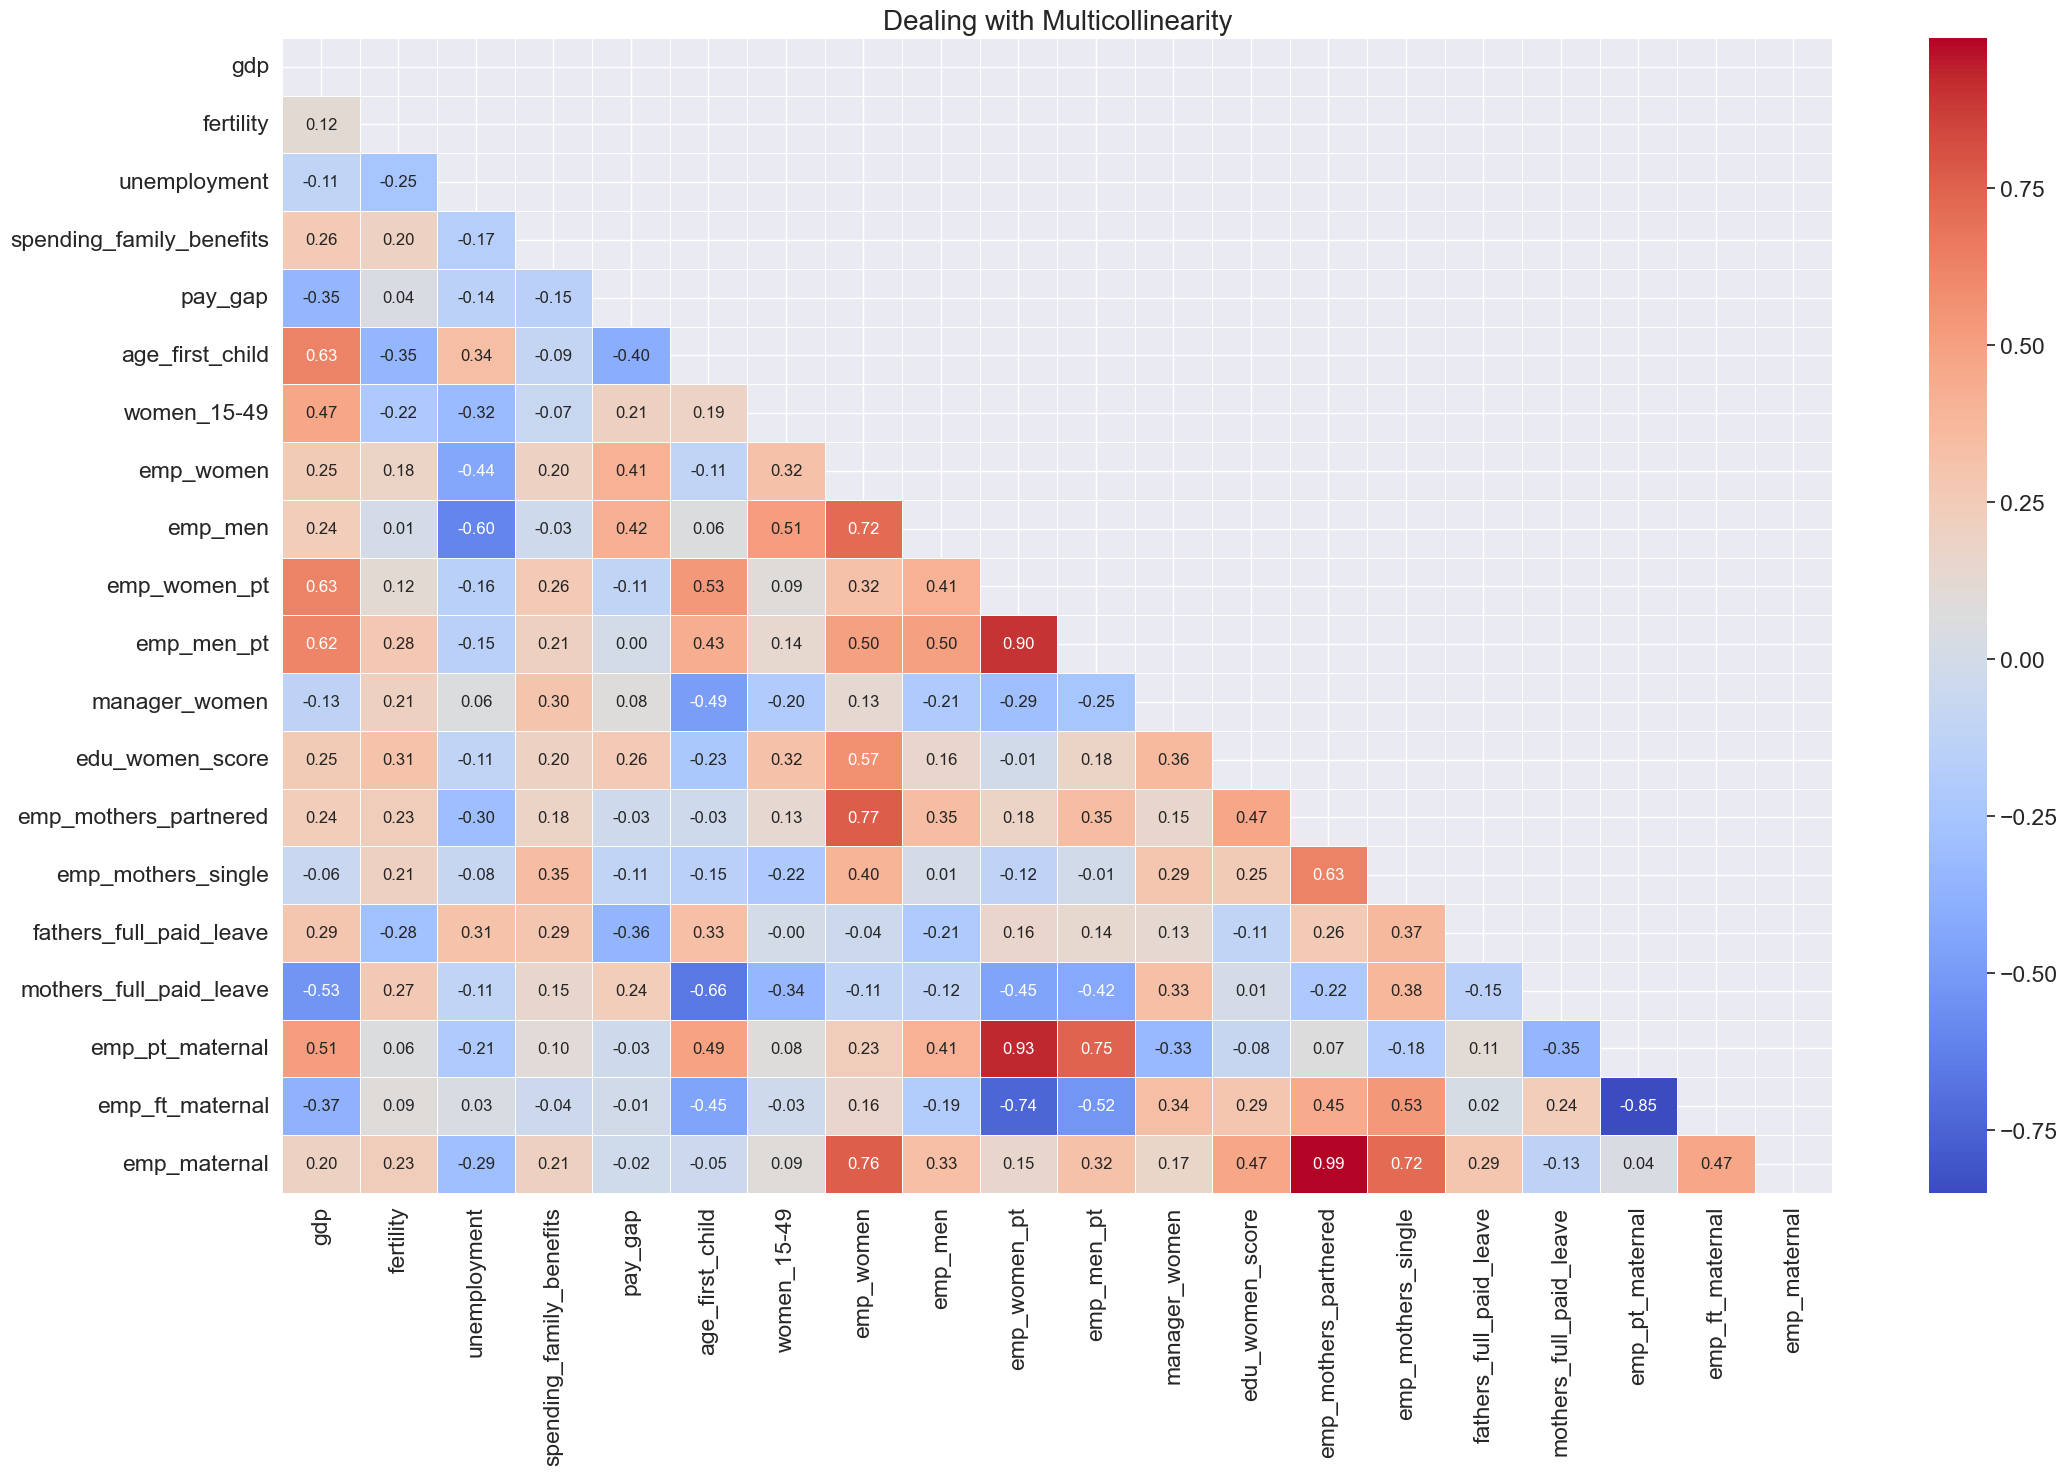

In [47]:
num_regression = regression_df.select_dtypes(include=[np.number])

num_regression_corr = round(num_regression.corr(), 2)

# Correlation Matrix-Heatmap Plot which shows only half of numbers (so no doubles)
mask = np.zeros_like(num_regression_corr)
mask[np.triu_indices_from(mask)] = True # hide the upper triangle
f, ax = plt.subplots(figsize=(25, 15))
sns.set(font_scale=1.5)
ax = sns.heatmap(num_regression_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax)
ax.set_title("Dealing with Multicollinearity", fontsize=20)
plt.show()

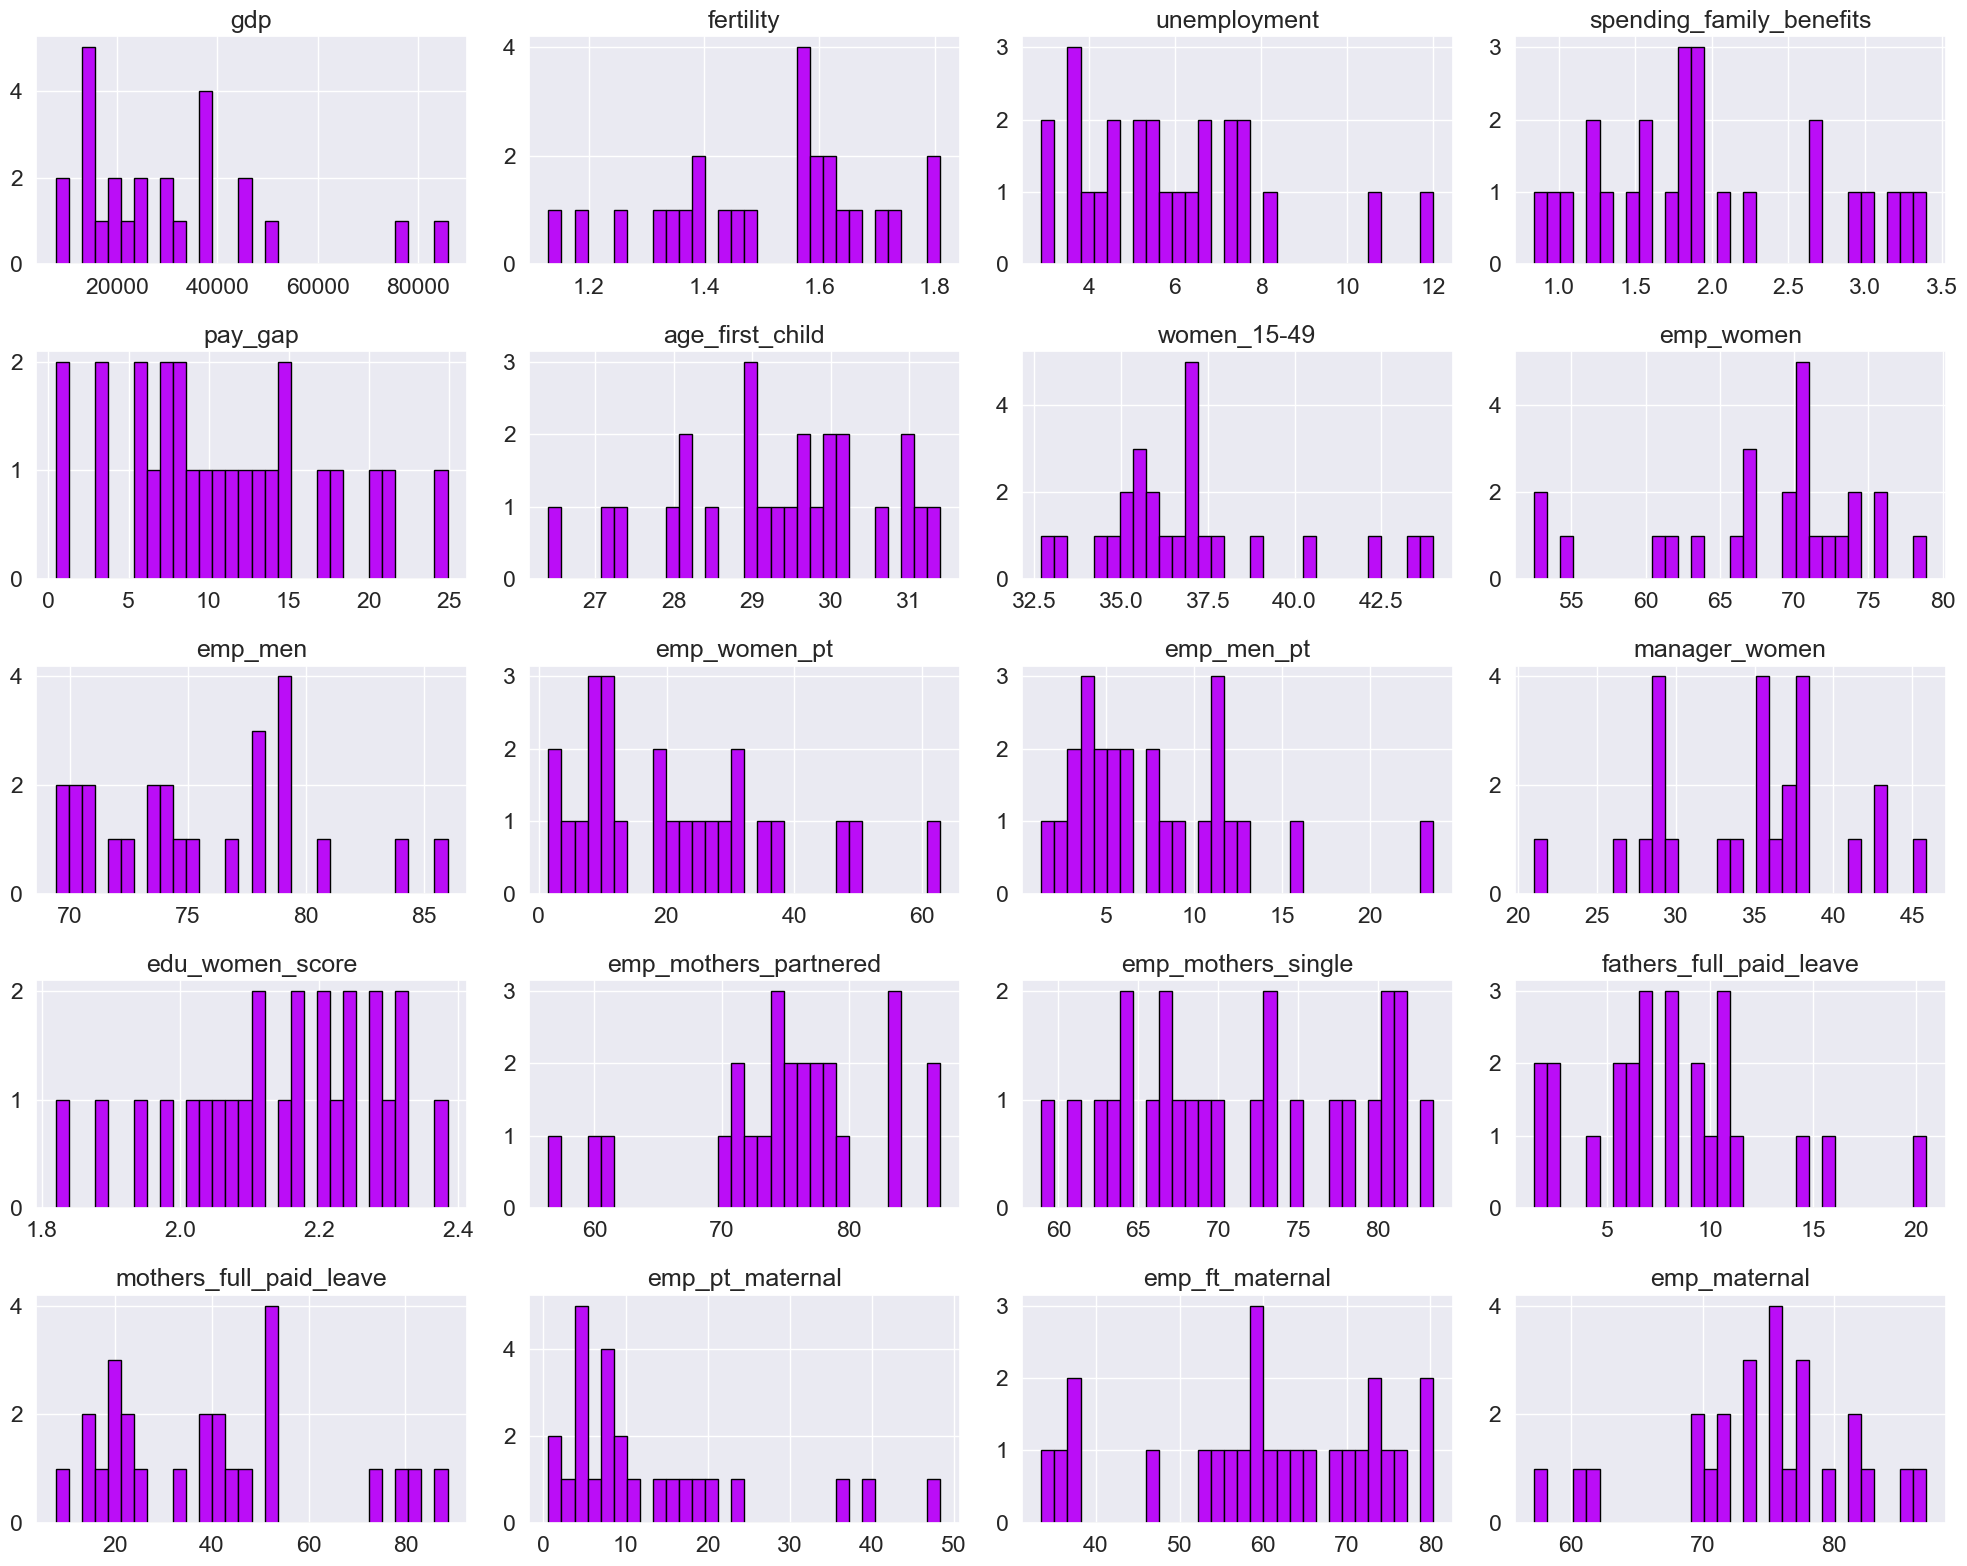

In [48]:
color = '#bb0df7'

# grid size
nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

# Plot each numerical feature
for i, ax in enumerate(axes):
    if i >= len(num_regression.columns):
        ax.set_visible(False)  # hide unesed plots
        continue
    ax.hist(num_regression.iloc[:, i], bins=30, color=color, edgecolor='black')
    ax.set_title(num_regression.columns[i])

plt.tight_layout()
plt.show()

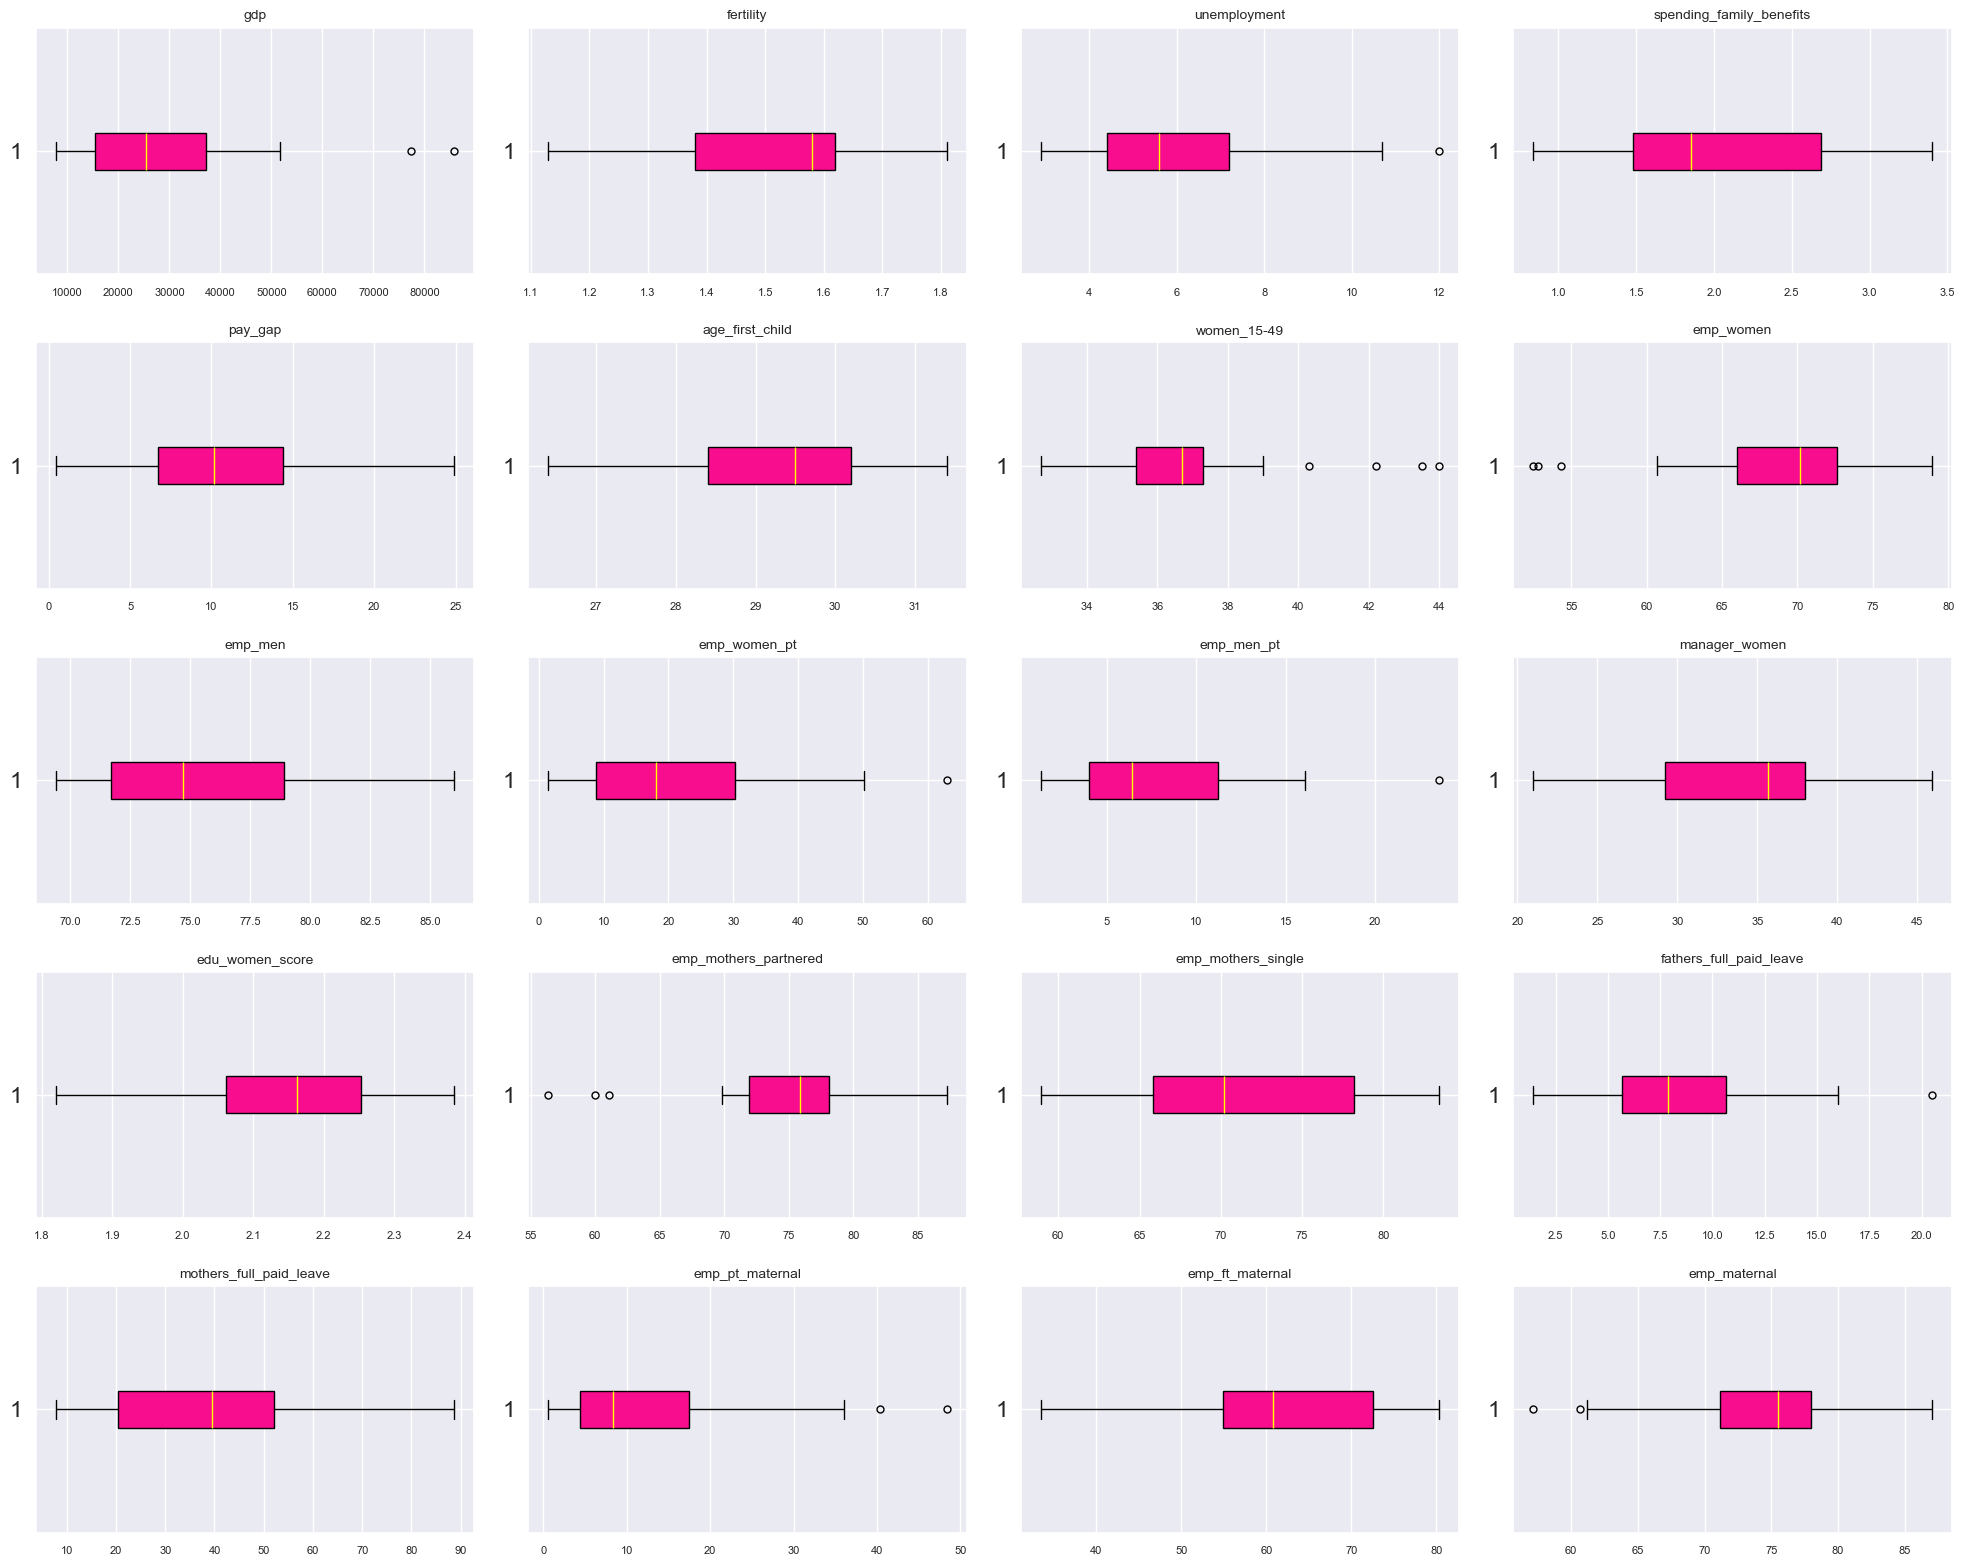

In [49]:
# boxplots for all num columns

color = '#f70d8d'

# grid size
nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num_regression.columns):
        ax.set_visible(False)
        continue
    ax.boxplot(num_regression.iloc[:, i].dropna(), vert=False, patch_artist=True, 
               boxprops=dict(facecolor=color, color='black'), 
               medianprops=dict(color='yellow'), whiskerprops=dict(color='black'), 
               capprops=dict(color='black'), flierprops=dict(marker='o', color='red', markersize=5))
    ax.set_title(num_regression.columns[i], fontsize=10)
    ax.tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

1. check linearity (scatterplots)
- **Linearity**: The relationship between the independent variables and the dependent variable is linear. This can be checked using scatter plots or partial regression plots.

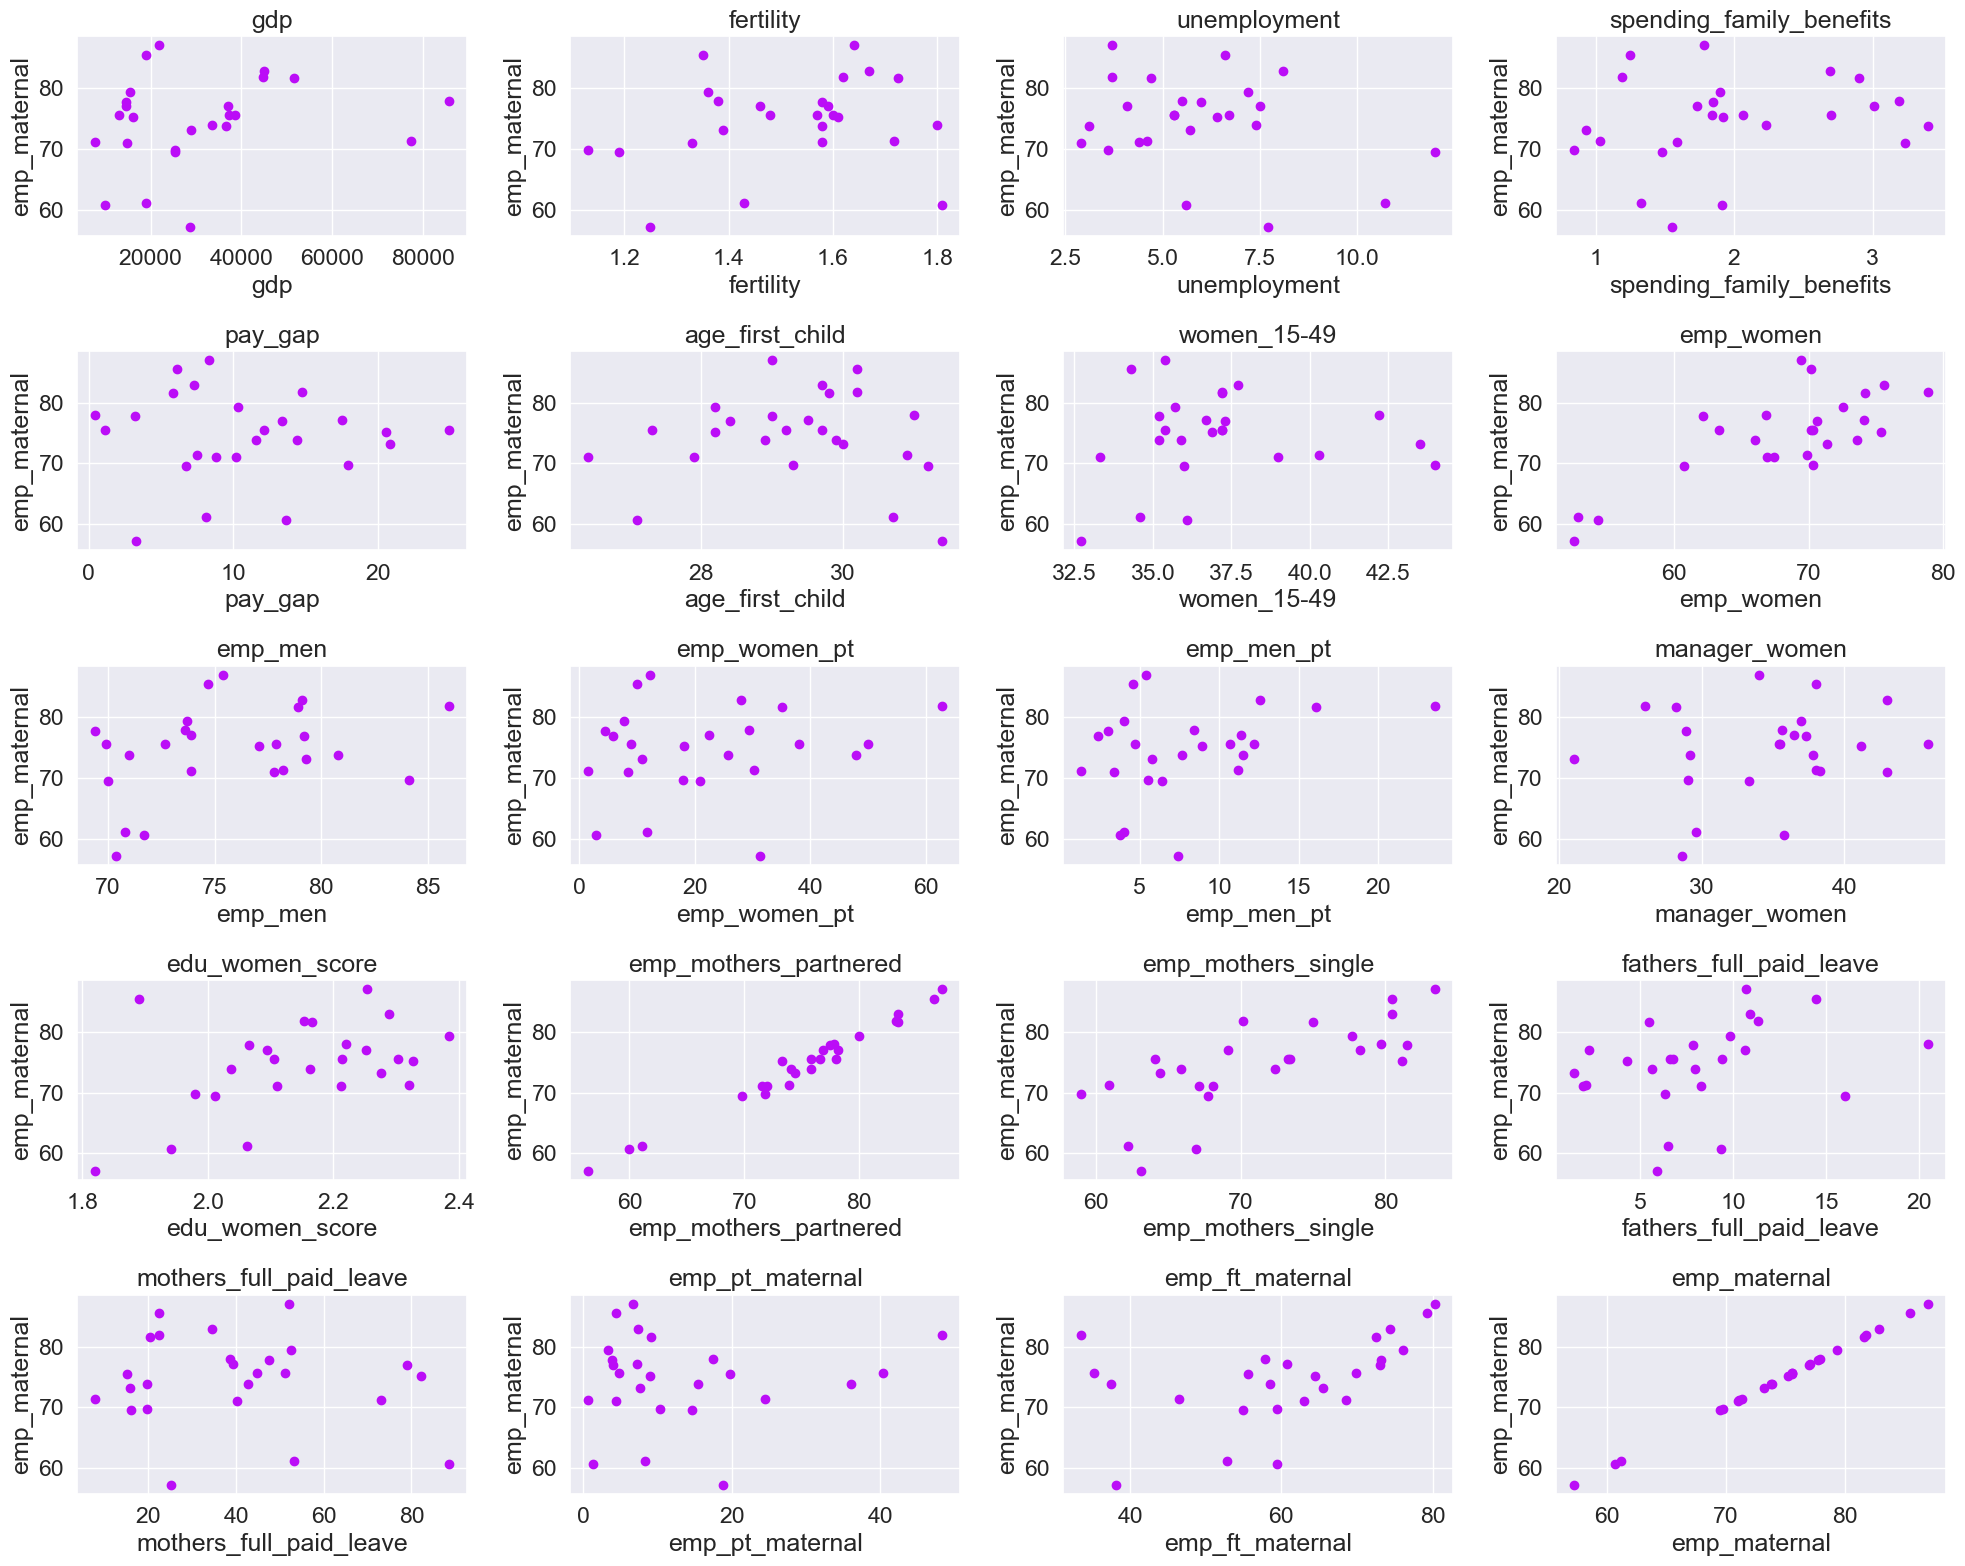

In [58]:
# scatterplots for all num columns

color = '#bb0df7'

# grid size
nrows, ncols = 5, 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num_regression.columns):
        ax.set_visible(False)
        continue
    ax.scatter(num_regression.iloc[:, i], num_regression['emp_maternal'], color=color)
    ax.set_title(num_regression.columns[i])
    ax.set_xlabel(num_regression.columns[i])
    ax.set_ylabel('emp_maternal')

plt.tight_layout()
plt.show()

2. - **Normality of Residuals**: The error terms (residuals) of the model are normally distributed. This assumption can be checked using a Q-Q plot or statistical tests like the Shapiro-Wilk test.

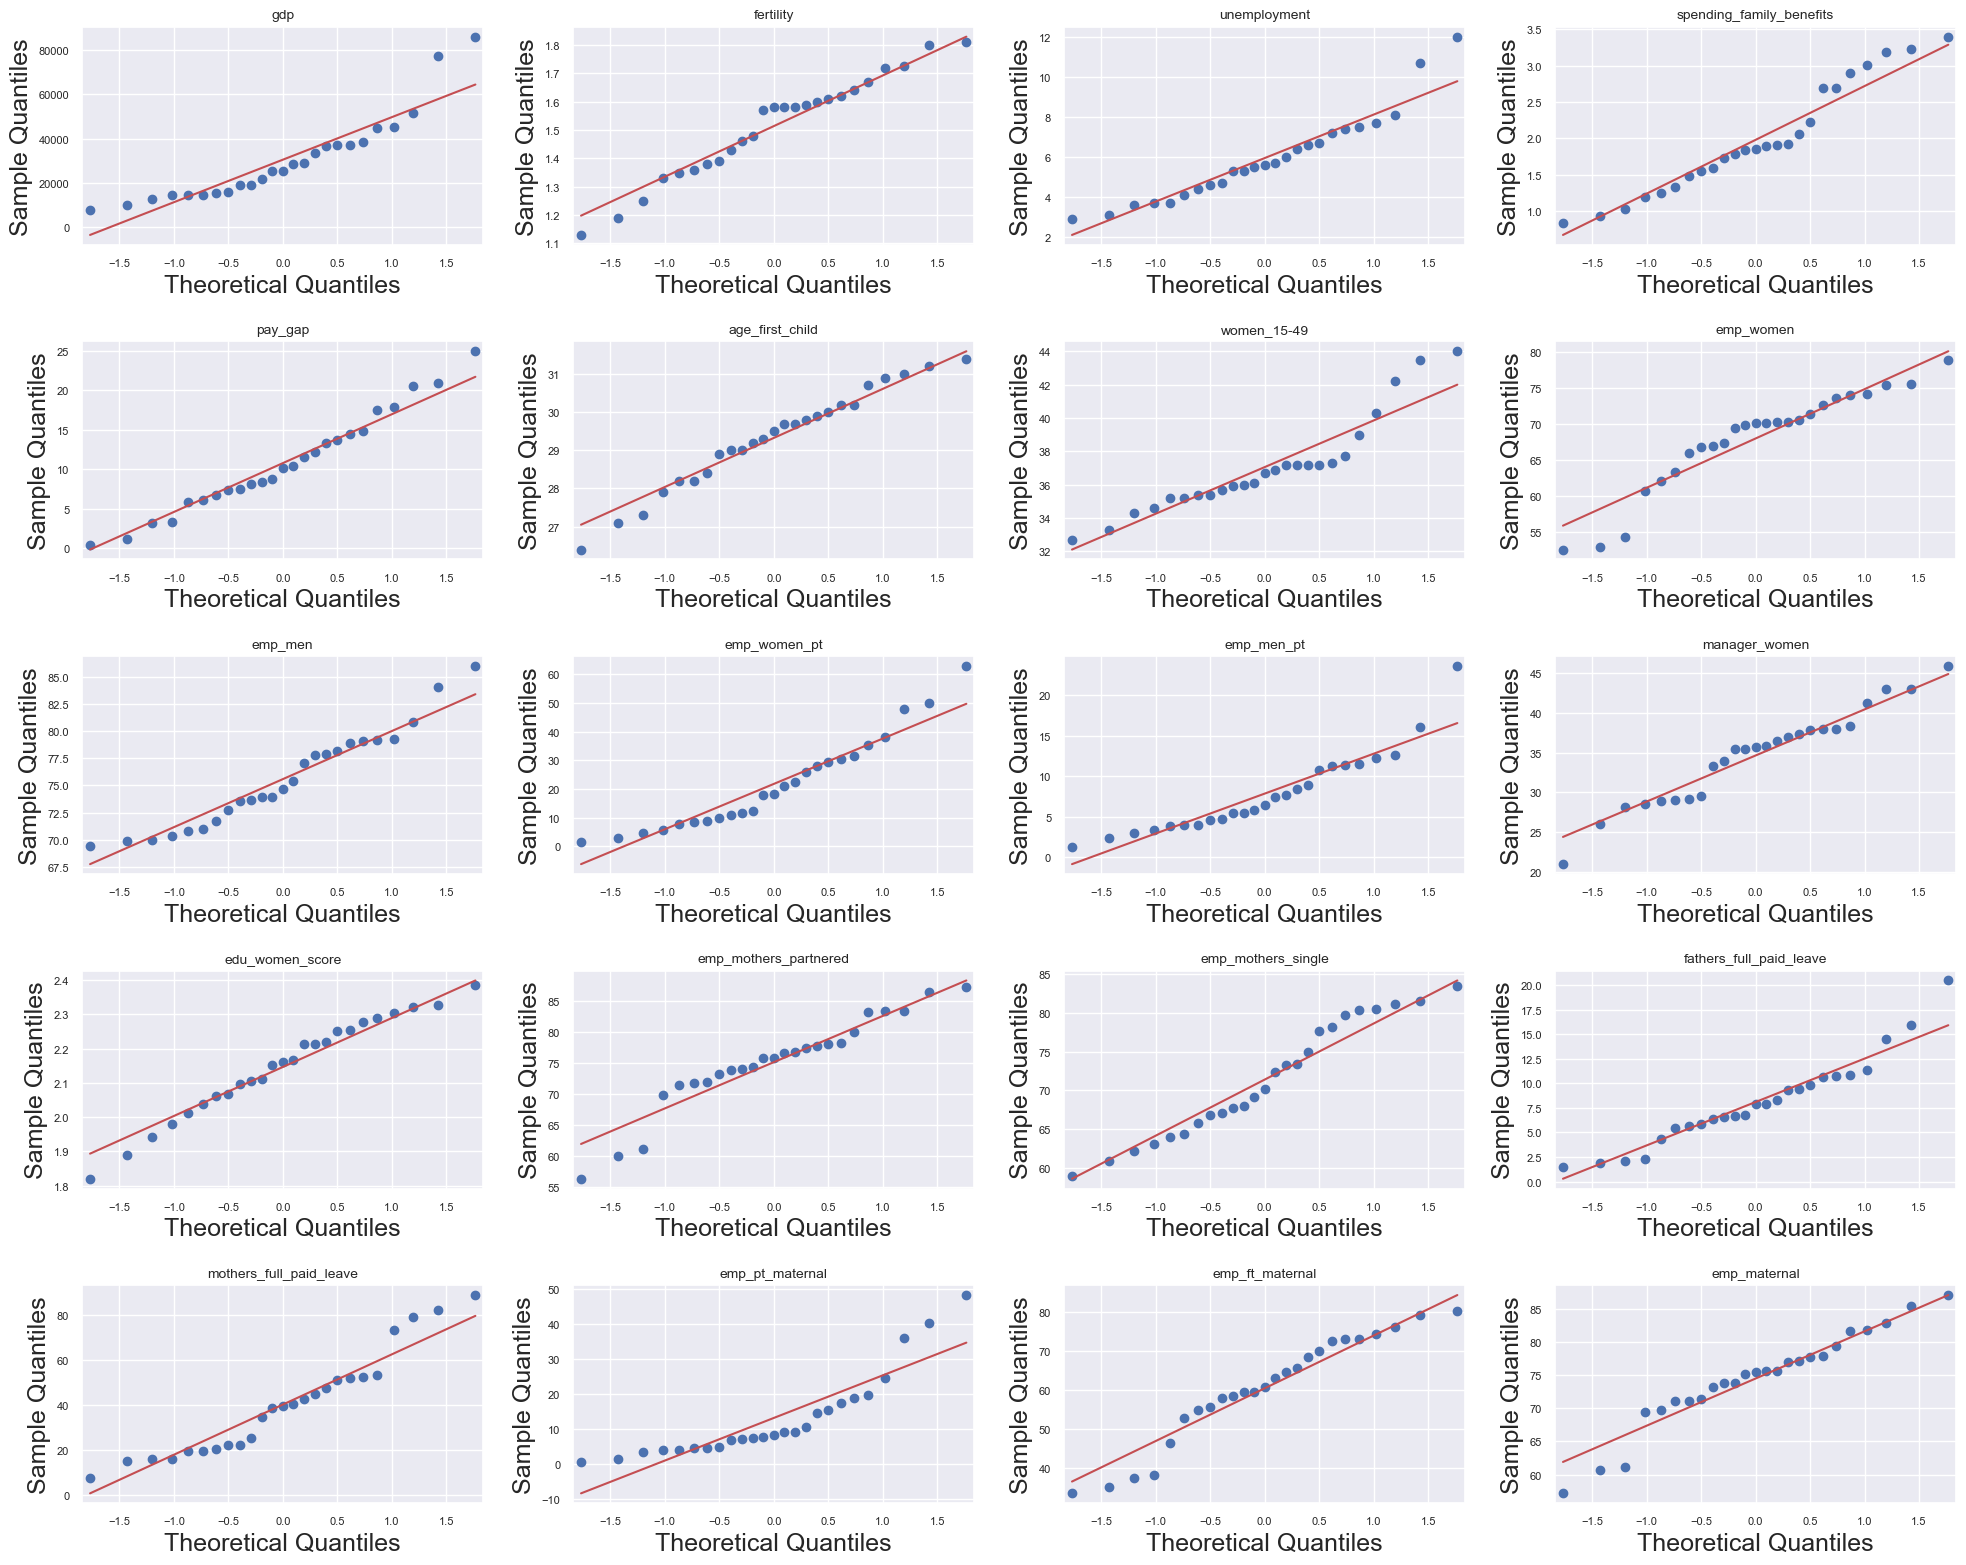

In [54]:
# qq plots for all num columns

# grid size
nrows, ncols = 5, 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num_regression.columns):
        ax.set_visible(False)
        continue
    sm.qqplot(num_regression.iloc[:, i].dropna(), line ='s', ax=ax)
    ax.set_title(num_regression.columns[i], fontsize=10)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()



In [56]:
# shapiro-wilk test for normality
alpha = 0.05
normality = []

for col in num_regression.columns:
    stat, p = stats.shapiro(num_regression[col].dropna())
    normality.append((col, p, p < alpha))

normality_df = pd.DataFrame(normality, columns=["Feature", "p-value", "Normality"])
normality_df


,Feature,p-value,Normality
0,gdp,0.00,True
1,fertility,0.49,False
2,unemployment,0.06,False
3,spending_family_benefits,0.14,False
4,pay_gap,0.74,False
5,age_first_child,0.68,False
6,women_15-49,0.01,True
7,emp_women,0.02,True
8,emp_men,0.18,False
9,emp_women_pt,0.06,False


3. - **No multicollinearity**: Independent variables are not too highly correlated. High correlation between predictors can lead to unstable estimates of regression coefficients. This can be checked using Variance Inflation Factor (VIF) scores.

In [55]:
# VIF for all numerical columns
vif_data = pd.DataFrame()
vif_data["feature"] = num_regression.columns
vif_data["VIF"] = [variance_inflation_factor(num_regression.values, i) for i in range(len(num_regression.columns))]
vif_data = vif_data.sort_values(by="VIF", ascending=False)

vif_data

,feature,VIF
19,emp_maternal,"148,158.32"
13,emp_mothers_partnered,"132,287.74"
18,emp_ft_maternal,"12,992.42"
5,age_first_child,"10,682.61"
8,emp_men,"10,238.24"
14,emp_mothers_single,"8,682.35"
7,emp_women,"4,297.31"
12,edu_women_score,"1,326.47"
17,emp_pt_maternal,"1,280.65"
6,women_15-49,978.20


4. ? normalisierung/ standardisierung?

? dropping features based on multicollinearity?

In [51]:
num_regression.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
gdp,"38,560.00","37,170.00","7,730.00","14,630.00","28,790.00","51,600.00","16,130.00","37,060.00","33,540.00","36,690.00","18,960.00","14,540.00","77,300.00","28,670.00","13,040.00","15,500.00","85,850.00","25,470.00","44,870.00","14,800.00","18,970.00","10,020.00","21,790.00","25,270.00","45,030.00"
fertility,1.48,1.60,1.58,1.58,1.39,1.72,1.61,1.46,1.80,1.58,1.43,1.59,1.72,1.25,1.57,1.36,1.38,1.13,1.62,1.33,1.35,1.81,1.64,1.19,1.67
unemployment,5.30,5.30,4.40,6.00,5.70,4.70,6.40,7.50,7.40,3.10,10.70,4.10,4.60,7.70,6.70,7.20,5.50,3.60,3.70,2.90,6.60,5.60,3.70,12.00,8.10
spending_family_benefits,2.70,2.06,1.59,1.85,0.93,2.90,1.92,3.01,2.23,3.40,1.33,1.73,1.03,1.55,1.84,1.90,3.19,0.84,1.19,3.23,1.25,1.91,1.78,1.48,2.69
pay_gap,12.14,1.11,8.81,3.21,20.84,5.84,20.52,17.52,11.56,14.38,8.08,13.34,7.47,3.29,24.91,10.34,0.44,17.89,14.76,10.17,6.10,13.64,8.32,6.72,7.30
age_first_child,29.70,29.20,26.40,29.00,30.00,29.80,28.20,29.50,28.90,29.90,30.70,28.40,30.90,31.40,27.30,28.20,31.00,29.30,30.20,27.90,30.20,27.10,29.00,31.20,29.70
women_15-49,37.20,37.20,33.30,35.20,43.50,37.20,36.90,36.70,35.90,35.20,34.60,37.30,40.30,32.70,35.40,35.70,42.20,44.00,37.20,39.00,34.30,36.10,35.40,36.00,37.70
emp_women,70.30,63.30,67.40,62.10,71.40,74.20,75.40,74.10,66.00,73.60,52.80,70.60,69.90,52.50,70.20,72.60,66.80,70.30,78.90,66.90,70.20,54.30,69.40,60.70,75.60
emp_men,77.90,69.90,73.90,69.40,79.30,78.90,77.10,73.90,71.00,80.80,70.80,79.20,78.20,70.40,72.70,73.70,73.60,84.10,86.00,77.80,74.70,71.70,75.40,70.00,79.10
emp_women_pt,50.10,38.10,1.50,4.50,10.90,35.20,18.10,22.40,25.80,47.90,11.70,5.80,30.30,31.40,8.90,7.70,29.40,17.90,62.90,8.40,10.00,2.90,12.20,21.00,28.00


In [52]:
# numerical variables without target variable
num_regression_final = num_regression.drop(columns=["emp_maternal"])

# define independent and dependent variables
X = num_regression_final
y = regression_df["emp_maternal"]

# multicollinearity check (VIF, Variance Inflation Factor)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# iterative VIF-filtering until all VIF values are below 10 (as multicollinearity can change after removing a variable)
while vif_data["VIF"].max() > 10:
    max_vif_var = vif_data.loc[vif_data["VIF"].idxmax(), "Variable"]
    X = X.drop(columns=[max_vif_var])
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# add constant term
X = sm.add_constant(X)

# execute OLS regression
model = sm.OLS(y, X).fit()

print("\n--- Variance Inflation Factor (VIF) nach Filterung ---")
print(vif_data)

print("\n--- Regression Summary ---")
print(model.summary())



--- Variance Inflation Factor (VIF) nach Filterung ---
                  Variable  VIF
0                      gdp 4.87
1             unemployment 6.83
2                  pay_gap 4.08
3  fathers_full_paid_leave 5.77
4  mothers_full_paid_leave 4.04
5          emp_pt_maternal 3.14

--- Regression Summary ---
                            OLS Regression Results                            
Dep. Variable:           emp_maternal   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     1.245
Date:                Sun, 09 Feb 2025   Prob (F-statistic):              0.330
Time:                        18:24:55   Log-Likelihood:                -80.198
No. Observations:                  25   AIC:                             174.4
Df Residuals:                      18   BIC:                             182.9
Df Model:                           6                       

<h1 style="color: #e3db24;">04 | Data Processing</h1>

<h2 style="color: #ec7511;">X-Y Split</h2>

<h2 style="color: #ec7511;">Normalizing the Data</h2>

<h1 style="color: #e3db24;">05 | Modeling</h1>

<h2 style="color: #ec7511;">Train-Test Split</h2>

<h2 style="color: #ec7511;">Model Validation</h2>

<h1 style="color: #e3db24;">06 | Improving the Model</h1>

<h1 style="color: #e3db24;">07 | Reporting</h1>